In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
ticker = yf.Ticker("ELET3.SA")
ticker

{'regularMarketPrice': None, 'logo_url': ''}

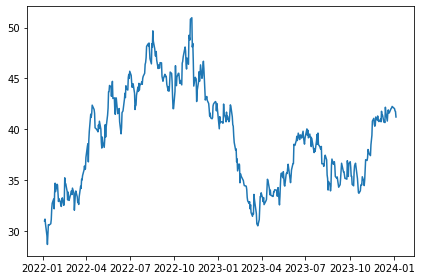

In [16]:
data_series = ticker.history(period="2y")
plt.plot(data_series.index,data_series['Open'])
plt.tight_layout()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0D7A6D940>]],
      dtype=object)

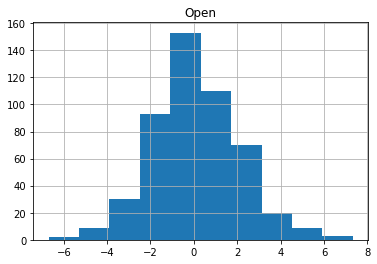

In [24]:
daily_return = data_series[['Open']].pct_change()*100
daily_return.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0DB486AC8>]],
      dtype=object)

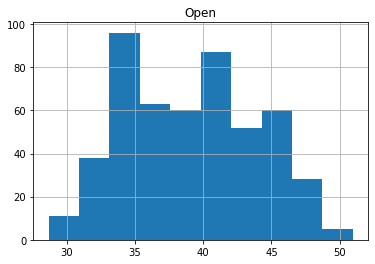

In [21]:
data_series[['Open']].hist(bins = 'sturges')